In [1]:
DATA_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/'
GRAPH_PATH = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/'
SAMPLE_SIZE = 1_000_000
window = 60000
shift = 10000
features = ['API_SESSION', 'API_TOKEN', 'AUTH_CODE',
            'EMAIL', 'JSESSION_ID', 'LOGIN', 'MESSENGER', 'PHONE',
            'SOCIAL_API_TOKEN', 'TWO_FACTOR', 'USER_ID_TYPE',
            'USER_ID_NO_PASSWORD']

In [2]:
!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import user_agents
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz

from random import *

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
columns=['USER_ID', 'TIMESTAMP', 'LOGIN_CREDENTIAL_TYPE']
botsLogins = pq.read_table(DATA_DIR + 'botsLogins.parquet', columns=columns).to_pandas().head(SAMPLE_SIZE >> 1)
usersLogins = pq.read_table(DATA_DIR + 'usersLogins.parquet', columns=columns).to_pandas().head(SAMPLE_SIZE >> 1)

In [4]:
botsLogins['isBot'] = 1
usersLogins['isBot'] = 0
logins = botsLogins.append(usersLogins)

In [5]:
def time_preprocessing(window, shift):
    ts_min = logins['TIMESTAMP'].min()
    nshift = int(window / shift)
    window_count = pd.DataFrame()
    for i in range(0, int(window / shift)):
        ts_i_col = "TS_PART_".format(i)
        logins[ts_i_col] = logins['TIMESTAMP'].apply(lambda x: int((x - ts_min + i * shift) / window) * nshift + i)
        ts_part_cred_count = logins.groupby([ts_i_col,'USER_ID', 'isBot', 'LOGIN_CREDENTIAL_TYPE']).size().unstack(fill_value=0)
        ts_part_cred_count.rename(index=str, columns={"USER_ID": "USER_ID_TYPE", ts_i_col : "TS_PART"}, inplace=True)
        ts_part_cred_count.reset_index(inplace=True)
        window_count = window_count.append(ts_part_cred_count)
    return window_count

def feature_preprocessing(window_count, features):
    X = window_count.loc[:, window_count.columns.isin(features)]
    y = window_count['isBot'].astype('int64')
    return X, y


In [6]:
window_count = time_preprocessing(window, shift)
window_count
X, y = feature_preprocessing(window_count, features)

In [7]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

In [8]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
f1_score(y_holdout, forest.predict(X_holdout))

0.6568557258898946

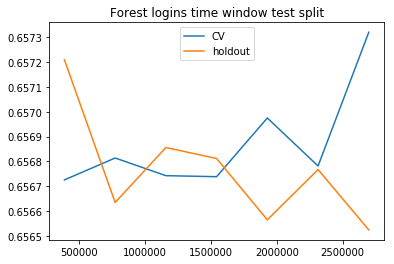

In [9]:
cv_scores, holdout_scores = [], []
split = np.arange(0.1, 0.8, 0.1)

for i in split:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=i, random_state=17)
    forest = RandomForestClassifier(n_jobs=-1, random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=2, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.plot(split * X.shape[0], cv_scores, label='CV')
plt.plot(split * X.shape[0], holdout_scores, label='holdout')
plt.title('Forest logins time window test split')
plt.savefig(GRAPH_PATH + 'forest_logins_time_window_testsplit.png', dpi=900)
plt.legend();